### Carga de Base de datos y Librerias

In [2]:
# Cargamos todas las librerias que vamos a necesitar y abrimos la ruta al repositorio

# PARTE 1
!pip install openpyxl
!pip install matplotlib pandas
!pip install pandas pyreadstat
!pip install pandas numpy scikit-learn matplotlib
!pip install seaborn

import pandas as pd
import os # Exportamos este módulo para trabajar con carpetas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# PARTE 2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score


#Cargamos el archivo desde el directorio del GitHub
base_dir = os.getcwd() # Construye la ruta relativa al archivo CSV desde el directorio actual

In [150]:
excel_path = os.path.join(base_dir, 'usu_hogar_T124.xlsx')
hogar_eph24 = pd.read_excel(excel_path)
hogar_eph04 = pd.read_stata('Hogar_t104.dta')
datos_individual = pd.read_csv('datos_individual.csv', low_memory=False)
datos_individual_original = pd.read_csv('datos_individual.csv', low_memory=False)

### Limpieza de Datos

#### Creamos base única

In [151]:
# NOS QUEDAMOS CON LOS DATOS DEL GRAN BUENOS AIRES en las dos bases de datos

# 2004
hogar_eph04= hogar_eph04[hogar_eph04['region']=='Gran Buenos Aires']
# 2024
hogar_eph24=hogar_eph24[hogar_eph24['REGION']==1]

In [152]:
# COINCIDENCIA DE COLUMNAS

#2004
hogar_eph04.columns = hogar_eph04.columns.str.lower()
#2024
hogar_eph24.columns = hogar_eph24.columns.str.lower()


combined_df = pd.concat([hogar_eph24, hogar_eph04], ignore_index=True, sort=False)

# Identifica columnas no compartidas
columns_df1 = set(hogar_eph04.columns)
columns_df2 = set(hogar_eph24.columns)

only_in_df1 = columns_df1 - columns_df2
only_in_df2 = columns_df2 - columns_df1

print("Columnas en 2004 pero no en 2024:", only_in_df1)
print("Columnas en 2024 pero no en 2004:", only_in_df2)

columns_to_remove_2004 = only_in_df1
columns_to_remove_2024 = only_in_df2

# Elimina las columnas de 2004
hogar_eph04 = hogar_eph04.drop(columns=columns_to_remove_2004, errors='ignore')

# Elimina las columnas de 2024
hogar_eph24 = hogar_eph24.drop(columns=columns_to_remove_2024, errors='ignore')

Columnas en 2004 pero no en 2024: {'idimph'}
Columnas en 2024 pero no en 2004: {'pondih'}


In [153]:
# CREAM0S UNICO DATA FRAME
df_hogar = pd.concat([hogar_eph04, hogar_eph24], ignore_index=True, sort=False)

In [154]:
df_hogar

,codusu,nro_hogar,realizada,ano4,trimestre,region,mas_500,aglomerado,pondera,iv1,...,rdeccfr,gdeccfr,pdeccfr,adeccfr,vii1_1,vii1_2,vii2_1,vii2_2,vii2_3,vii2_4
0,125098,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Departamento,...,06,06,,04,1.0,0.0,98.0,0.0,0.0,0.0
1,125397,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,2018.0,Departamento,...,00,00,,00,1.0,0.0,98.0,0.0,0.0,0.0
2,125515,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Departamento,...,07,07,,05,1.0,0.0,98.0,0.0,0.0,0.0
3,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,08,08,,06,2.0,0.0,3.0,4.0,0.0,0.0
4,125599,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1471.0,Casa,...,04,04,,02,2.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,TQRMNOPSSHKMROCDEIJAH00861731,1.0,1,2024.0,1,1,S,33,3772.0,1,...,10,10.0,NaN,10,1,0,96,0,0,0
4892,TQRMNOPWVHJLSSCDEIJAH00794914,1.0,1,2024.0,1,1,S,33,1862.0,1,...,2,2.0,NaN,2,4,2,98,0,0,0
4893,TQRMNOQQWHKMOQCDEIJAH00861732,1.0,1,2024.0,1,1,S,33,2639.0,1,...,12,12.0,NaN,12,2,0,98,0,0,0
4894,TQRMNOSXRHKMNMCDEIJAH00861733,1.0,1,2024.0,1,1,S,33,1497.0,2,...,10,10.0,NaN,10,1,0,98,0,0,0


In [155]:
num_columnas = datos_individual.shape[1]
print(f"El DataFrame tiene {num_columnas} columnas.")

# Crear las columnas dummy para los diferentes componentes

datos_individual['componente'] = datos_individual['componente'].astype(str)

# Generar las dummies basadas en los valores de 'componente'
df_individual_dummy = pd.get_dummies(datos_individual['componente'], prefix='componente')

# Corregir los nombres de columnas redundantes (por ejemplo, 'componente_1' y 'componente_1.0')
for col in df_individual_dummy.columns:
    if '.' in col:  # Si la columna tiene un sufijo (como '.0')
        base_col = col.split('.')[0]  # Obtener el nombre base de la columna, sin el sufijo
        if base_col in df_individual_dummy.columns:
            # Sumar las columnas con el mismo nombre base (1 + 1 = 2, pero lo corregiremos a True/False)
            df_individual_dummy[base_col] = df_individual_dummy[base_col] | df_individual_dummy[col]  # Unión lógica (OR)
            # Eliminar la columna con el sufijo
            df_individual_dummy = df_individual_dummy.drop(columns=[col])

# Combinar las dummies con el DataFrame original
datos_individual = pd.concat([datos_individual, df_individual_dummy], axis=1)

# Ahora realizamos el `groupby` sobre todas las columnas, asegurándonos de mantener las originales.
# Aplicamos `max()` para las columnas dummies y `first()` para las demás columnas (como 'codusu', 'nro_hogar').

columnas_dummies = [col for col in df_individual_dummy.columns if col.startswith('componente_')]
columnas_originales = [col for col in datos_individual.columns if col not in columnas_dummies]

# Realizamos el groupby sobre todas las columnas
datos_individual = datos_individual.groupby(['codusu', 'nro_hogar'], as_index=False).agg(
    {**{col: 'max' for col in columnas_dummies}, **{col: 'first' for col in columnas_originales}}
)

# Resultado
print(datos_individual)

# Mostrar la cantidad de columnas finales y sus nombres
num_columnas = datos_individual.shape[1]
print(f"El DataFrame tiene {num_columnas} columnas después de agrupar.")
print(f"Columnas finales: {datos_individual.columns.tolist()}")

El DataFrame tiene 172 columnas.
      componente_1  componente_10  componente_11  componente_12  \
0             True          False          False          False   
1             True          False          False          False   
2             True          False          False          False   
3             True          False          False          False   
4             True          False          False          False   
...            ...            ...            ...            ...   
4668          True          False          False          False   
4669          True          False          False          False   
4670          True          False          False          False   
4671          True          False          False          False   
4672          True          False          False          False   

      componente_13  componente_14.0  componente_15.0  componente_2  \
0             False            False            False          True   
1             False 

In [156]:
# Hacer el merge con el parámetro indicator=True para agregar la columna '_merge'

#df_hogar = df_hogar.drop_duplicates(subset=['codusu', 'nro_hogar'])

df_completa = pd.merge(df_hogar, datos_individual, on=['codusu', 'nro_hogar'], indicator=False)
print(df_completa.columns.tolist())

# Mostrar los resultados
print(f"Filas solo en df_hogar: {len(df_hogar)}")
print(f"Filas solo en datos_individual: {len(datos_individual)}")
print(f"Filas en ambos DataFrames: {len(df_completa)}")
print("Columnas en df_hogar:", df_hogar.columns.tolist())
print("Columnas en datos_individual:", datos_individual.columns.tolist())

print(f"Duplicados en df_hogar: {df_hogar[['codusu', 'nro_hogar']].duplicated().sum()}")
print(f"Duplicados en datos_individual: {datos_individual[['codusu', 'nro_hogar']].duplicated().sum()}")
# Ver las filas que no tienen coincidencia
#print("\nFilas solo en df_hogar (sin coincidencia en datos_individual):")
#print(solo_df_hogar)


# Verifica si hay valores nulos en las claves de unión
print("Valores nulos en 'codusu' de df_hogar:", df_hogar['codusu'].isnull().sum())
print("Valores nulos en 'nro_hogar' de df_hogar:", df_hogar['nro_hogar'].isnull().sum())
print("Valores nulos en 'codusu' de datos_individual:", datos_individual['codusu'].isnull().sum())
print("Valores nulos en 'nro_hogar' de datos_individual:", datos_individual['nro_hogar'].isnull().sum())


coincidencias_codusu = df_hogar['codusu'].isin(datos_individual['codusu']).sum()
coincidencias_nro_hogar = df_hogar['nro_hogar'].isin(datos_individual['nro_hogar']).sum()



print(f"Coincidencias de 'codusu': {coincidencias_codusu} de {len(df_hogar)} en df_hogar están en datos_individual")
print(f"Coincidencias de 'nro_hogar': {coincidencias_nro_hogar} de {len(df_hogar)} en df_hogar están en datos_individual")


#print("\nFilas solo en datos_individual (sin coincidencia en df_hogar):")
#print(datos_individual[['codusu', 'nro_hogar']])


completos = df_hogar[df_hogar['codusu'].isin(datos_individual['codusu']) & df_hogar['nro_hogar'].isin(datos_individual['nro_hogar'])]

print(f"Filas con coincidencia completa (tanto 'codusu' como 'nro_hogar'): {len(completos)}")
# Combinar las columnas que tienen los mismos nombres en ambos DataFrames
columns_to_combine = []

['codusu', 'nro_hogar', 'realizada', 'ano4_x', 'trimestre_x', 'region_x', 'mas_500_x', 'aglomerado_x', 'pondera_x', 'iv1', 'iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv5', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf_x', 'decifr_x', 'idecifr_x', 'rdecifr_x', 'gdecifr_x', 'pdecifr_x', 'adecifr_x', 'ipcf_x', 'deccfr_x', 'ideccfr_x', 'rdeccfr_x', 'gdeccfr_x', 'pdeccfr_x', 'adeccfr_x', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'componente_1', 'componente_10', 'componente_11', 'componente_12', 'componente_13', 'componente_14.0', 'componente_15.0', 'componente_2', 'componente_3', 'componente_4', 'componente_5', 'compo

In [157]:
columns_to_combine = []
for col in df_hogar.columns:
    if col in datos_individual.columns:
        # Verificar si las columnas con sufijos _x y _y existen
        if col + '_x' in df_completa.columns and col + '_y' in df_completa.columns:
            
            # Comprobar si alguna de las columnas es de tipo numérico
            is_numeric_x = pd.api.types.is_numeric_dtype(df_completa[col + '_x'])
            is_numeric_y = pd.api.types.is_numeric_dtype(df_completa[col + '_y'])
            
            if is_numeric_x and is_numeric_y:
                # Si ambas columnas son numéricas, quedarse con la que tiene más datos no NaN
                if df_completa[col + '_x'].notna().sum() >= df_completa[col + '_y'].notna().sum():
                    df_completa[col] = df_completa[col + '_x']
                else:
                    df_completa[col] = df_completa[col + '_y']
            elif is_numeric_x:
                # Si solo la columna _x es numérica
                df_completa[col] = df_completa[col + '_x']
            elif is_numeric_y:
                # Si solo la columna _y es numérica
                df_completa[col] = df_completa[col + '_y']
            else:
                # Si ninguna de las columnas es numérica, se podría usar alguna lógica adicional,
                # pero por ahora se deja a las dos columnas con valores no numéricos.
                # Aquí puedes agregar lo que desees hacer si ambas son no numéricas.
                df_completa[col] = df_completa[col + '_x'].combine_first(df_completa[col + '_y'])
            
            # Eliminar las columnas con sufijos _x y _y
            df_completa.drop([col + '_x', col + '_y'], axis=1, inplace=True)

In [158]:
df_completa
df_completa.to_csv("C:/Users/Mili/Downloads/rtrtrtrtetretert.csv", index=False)

####  Valores faltantes 

In [159]:
# Eliminar las columnas donde todas las filas son NaN
df_completa = df_completa.replace({'...': np.nan, 0: np.nan, -9: np.nan, 9: np.nan})

# Eliminar las columnas que contienen solo NaN
df_completa = df_completa.dropna(axis=1, how='all')


# Eliminar columnas que contienen solo NaN
df_completa = df_completa.dropna(axis=1, how='all')
# SACA 2

C:\Users\Mili\AppData\Local\Temp\ipykernel_5732\3113344656.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_completa = df_completa.replace({'...': np.nan, 0: np.nan, -9: np.nan, 9: np.nan})


In [160]:
# Obtener los nombres de las columnas con valores NaN
print("CON ALGUN NAN:")
col = df_completa.columns[df_completa.isna().any()]
col_list = col.tolist()
print(col_list)

print("SIN NINGUN NAN:")
col_no_nan = df_completa.columns[df_completa.notna().all()]
col_no_nan_list = col_no_nan.tolist()
print(col_no_nan_list)

CON ALGUN NAN:
['iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'h15', 'ch03', 'ch06', 'ch08', 'ch14', 'ch15_cod', 'ch16_cod', 'estado', 'cat_inac', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 

In [161]:
#FILAS CON NAN
df_completa = df_completa.dropna(subset=['cat_inac'])
df_completa = df_completa.dropna(subset=['itf'])

#COLUMNAS A ELIMINAR (vARIABLES NO CONSIDERADAS RELEVANTES)
df_completa = df_completa.drop(columns=['iv2', 'iv3', 'iv3_esp', 'iv4', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11']) #caracteristicas de la casa
df_completa = df_completa.drop(columns=['ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9']) #ii3 (ocupa casa para trabajar) y ii7 (regimen de tenencia del hogar) se quedan

In [162]:
df_completa

,codusu,nro_hogar,realizada,iv1,iv1_esp,iv5,iv12_1,iv12_2,iv12_3,ii1,...,gdecifr,pdecifr,adecifr,ipcf,deccfr,ideccfr,rdeccfr,gdeccfr,pdeccfr,adeccfr
0,125098,1.0,Sí,Departamento,,Sí,No,No,No,3.0,...,2.0,,1.0,368.0,7.0,,6.0,6.0,,4.0
1,125515,1.0,Sí,Departamento,,Sí,No,No,No,2.0,...,3.0,,2.0,440.0,7.0,,7.0,7.0,,5.0
5,125854,1.0,Sí,Departamento,,Sí,No,No,No,2.0,...,8.0,,7.0,735.0,NaN,,NaN,NaN,,7.0
11,127045,1.0,Sí,Departamento,,Sí,No,No,No,2.0,...,2.0,,1.0,180.0,4.0,,3.0,4.0,,1.0
13,127406,1.0,Sí,Departamento,,Sí,No,No,No,2.0,...,4.0,,3.0,311.0,6.0,,6.0,6.0,,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4656,TQRMNOSPXHJOONCDEIJAH00861729,1.0,1,1,NaN,1,2,2,2,3.0,...,4.0,None,5.0,200000.0,6.0,None,5.0,5.0,None,6.0
4663,TQRMNOSWWHMNSMCDEIJAH00802091,1.0,1,1,NaN,1,2,2,2,3.0,...,5.0,None,5.0,210000.0,6.0,None,6.0,6.0,None,6.0
4664,TQRMNOSRUHJNSOCDEIJAH00855687,1.0,1,1,NaN,1,2,2,2,3.0,...,4.0,None,4.0,170000.0,5.0,None,5.0,5.0,None,5.0
4666,TQRMNORQPHJOSPCDEIJAH00794445,1.0,1,1,NaN,2,2,2,2,2.0,...,2.0,None,2.0,210000.0,6.0,None,6.0,6.0,None,6.0


In [163]:
column_types = df_completa.dtypes

# Crear una función para identificar columnas con tipos de datos mezclados
def columnas_tipos_mixtos(df):
    columnas_mixtas = []
    for columna in df.columns:
        tipos_unicos = df[columna].apply(type).unique()  # Obtener tipos únicos en la columna
        if len(tipos_unicos) > 1:  # Si hay más de un tipo de dato en la columna
            columnas_mixtas.append(columna)
    return columnas_mixtas

# Llamar a la función para encontrar las columnas con tipos de datos mezclados
columnas_mixtas = columnas_tipos_mixtos(df_completa)

# Imprimir el resultado
print("Columnas con tipos de datos mezclados:", columnas_mixtas)
print("Columnas con tipos de datos mezclados:", len(columnas_mixtas))

Columnas con tipos de datos mezclados: ['realizada', 'iv1', 'iv1_esp', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'ii3', 'ii7', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'ch14', 'ch15_cod', 'ch16_cod', 'pp03c', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp09a', 'pp09a_esp', 'pp09c_esp', 'pp10a', 'pp10c', 'pp10d', 'pp10e', 'pp11a', 'pp11b_cod', 'pp11b1', 'pp11c', 'pp11c99', 'pp11d_cod', 'pp11l', 'pp11l1', 'pp11m', 'pp11n', 'pp11o', 'pp11p', 'pp11q', 'pp11r', 'pp11s', 'pp11t', 'idecocur', 'pdecocur', 'idec

####  Variables construidas

In [164]:
datos_individual_original = pd.read_csv('datos_individual.csv', low_memory=False)

In [165]:
# PROPORCION DE PERSONAS QUE TRABAJAN EN EL HOGAR Y CANTIDAD DE PERSONAS QUE VIVEN EN EL HOGAR.

trabajadores = datos_individual_original[datos_individual_original['estado'] == 1]  # Filtramos por las personas que están trabajando
total_personas_hogar = datos_individual_original.groupby(['codusu', 'nro_hogar']).size().reset_index(name='total_personas') #Agrupar por hogar y contar el TOTAL de personas en cada hogar
trabajadores_por_hogar = trabajadores.groupby(['codusu', 'nro_hogar']).size().reset_index(name='personas_trabajando') # Agrupar por hogar y contar el número de personas QUE TRABAJAN

proporcion_trabajadores = pd.merge(total_personas_hogar, trabajadores_por_hogar, on=['codusu', 'nro_hogar'], how='left') # Unimos los datos de trabajadores y el total de personas en cada hogar
proporcion_trabajadores['personas_trabajando'] = proporcion_trabajadores['personas_trabajando'].fillna(0) # Si no hay trabajadores en un hogar, rellenamos con 0
proporcion_trabajadores['proporcion_trabajando'] = proporcion_trabajadores['personas_trabajando'] / proporcion_trabajadores['total_personas'] # Calcular la proporción de trabajadores en cada hogar

# Resultado final: mostrar la proporción de trabajadores en cada hogar
proporcion_trabajadores['proporcion_trabajando'] = proporcion_trabajadores['proporcion_trabajando'].round(3)
print(proporcion_trabajadores[['codusu', 'nro_hogar', 'proporcion_trabajando']])

df_completa = pd.merge(df_completa, proporcion_trabajadores[['codusu', 'nro_hogar', 'proporcion_trabajando', 'total_personas']], on=['codusu', 'nro_hogar'], how='left')

                             codusu  nro_hogar  proporcion_trabajando
0                          125047          1.0                  0.000
1                          125098          1.0                  0.000
2                          125169          1.0                  0.333
3                          125172          2.0                  1.000
4                          125256          1.0                  0.667
...                             ...        ...                    ...
4668  TQTMNORTYHJOPMCDEIJAH00794674        1.0                  1.000
4669  TQTMNOSPRHMNROCDEIJAH00860644        1.0                  1.000
4670  TQTMNOSTRHLMKUCDEIJAH00861152        1.0                  0.333
4671  TQUMNOQSVHMOTSCDEIJAH00859221        1.0                  1.000
4672  TQVMNORVXHLOTOCDEIJAH00855319        1.0                  0.500

[4673 rows x 3 columns]


In [ ]:
# Combinar la antigüedad en el empleo (si tienes esa información) con el tipo de empleo (formal o informal). La combinación de estas variables podría dar un índice que represente la estabilidad laboral de los miembros del hogar.
# Fórmula: estabilidad_laboral = antigüedad_empleo * (1 - es_informal)

# Edad Promedio: La edad promedio de los miembros del hogar puede ser un predictor importante de la desocupación, ya que los hogares con más jóvenes pueden tener tasas de desempleo más altas.
# Fórmula: edad_promedio = suma_edades_hogar / total_personas

# Proporción de Personas en Edad de Trabajar: Combina la proporción de trabajadores con la proporción de personas en edad laboral (por ejemplo, entre 18 y 65 años).
# Fórmula: proporcion_trabajadores_edad = (personas_trabajando / total_personas) * (personas_en_edad_trabajar / total_personas)

####  Estadísticas Descriptivas

Frecuencias:
iv12_3
No    1149
Sí      11
Name: count, dtype: int64

Proporciones (%):
iv12_3
No    99.05
Sí     0.95
Name: proportion, dtype: float64


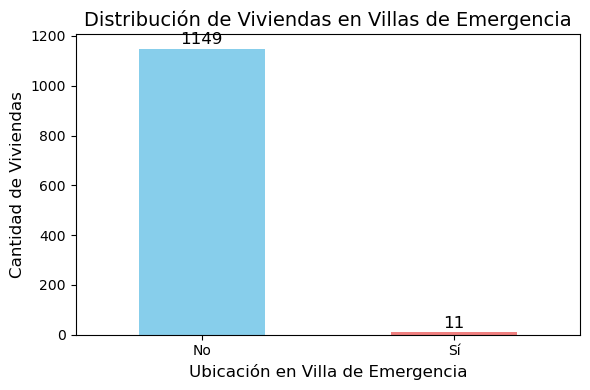

In [174]:
# Crear una copia temporal de la columna para trabajar
villa_observacion = df_completa['iv12_3'].replace({1: 'Sí', 2: 'No'})

# Calcular las frecuencias
frecuencias_villa = villa_observacion.value_counts()
print("Frecuencias:")
print(frecuencias_villa)

# Calcular las proporciones
proporciones_villa = villa_observacion.value_counts(normalize=True) * 100
print("\nProporciones (%):")
print(proporciones_villa.round(2))

plt.figure(figsize=(6, 4))
frecuencias_villa.plot(kind='bar', color=['skyblue', 'lightcoral'])

# Agregar título y etiquetas
plt.title('Distribución de Viviendas en Villas de Emergencia', fontsize=14)
plt.xlabel('Ubicación en Villa de Emergencia', fontsize=12)
plt.ylabel('Cantidad de Viviendas', fontsize=12)

# Mostrar los valores sobre las barras
for i, v in enumerate(frecuencias_villa):
    plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=12)

# Mostrar el gráfico
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# COMBINACION CON SI LA PERSONA TRABAJO ALGUNA VEZ

df_filtrado = df_completa[df_completa['pp10d'] != 0.0]

# Reemplazar los valores de IV12_3 N por etiquetas descriptivas (si no lo están ya)
df_filtrado['iv12_3'] = df_filtrado['iv12_3'].replace({1: 'Sí', 2: 'No'})

# Crear una tabla de contingencia para contar las frecuencias
contingencia = pd.crosstab(df_filtrado['iv12_3'], df_filtrado['pp10d'])

# Crear una tabla de porcentajes por fila
porcentajes = pd.crosstab(df_filtrado['iv12_3'], df_filtrado['pp10d'], normalize='index') * 100

In [ ]:
# COMBINACION CON SI LA PERSONA TRABAJO ALGUNA VEZ

In [ ]:
# V4 --> SEGURO DE DESEMPLEO

In [ ]:
# ???? Falta una

### Clasificación y regularización

In [ ]:
# USAR BASE RESPONDIERON. TENES QUE AGREGAR LOS DATOS QUE TIENE ESTA.

# IMPRIMI LAS COLUMNAS QUE ESTAN EN RESPONDIERON Y NO ESTAN EN COMPLETA Y MERGEA LAS QUE FALTAN SEGUN CODUSU Y NRO DE HOGAR 